In [1]:
import numpy as np
import torch
import torch.nn as nn
from utils import segment_features

In [2]:
test_data_1 = np.load('../../Data/scene_analysis/2_Florian_Heizung_aus.npy')
test_data_2 = np.load('../../Data/scene_analysis/3_Verena_Staubsauger_an_Alarm_an.npy')
test_data_3 = np.load('../../Data/scene_analysis/5_Lukas_Staubsauger_an_Licht_aus.npy')
test_data_4 = np.load('../../Data/scene_analysis/6_Deepak_Radio_aus_Licht_aus.npy')
test_data_5 = np.load('../../Data/development_scenes_npy/development_scenes/3_speech_true_Radio_an.npy')
print(f"Florian Heizung aus (Scene 1): {test_data_1.shape} "
      f"\nVerena Staubsauger an Alarm an (Scene 2): {test_data_2.shape} "
      f"\nLukas Staubsauger an Licht aus (Scene 3): {test_data_3.shape} "
      f"\nDeepak Radio aus Licht aus (Scene 4): {test_data_4.shape}"
      f"\n{test_data_5.shape}")

Florian Heizung aus (Scene 1): (1, 175, 854) 
Verena Staubsauger an Alarm an (Scene 2): (1, 175, 762) 
Lukas Staubsauger an Licht aus (Scene 3): (1, 175, 292) 
Deepak Radio aus Licht aus (Scene 4): (1, 175, 243)
(175, 1109)


In [3]:
use_mps = torch.backends.mps.is_available()
device = torch.device("mps" if use_mps else "cpu")

In [4]:
from model_architectures import EnhancedAudioCNN

def load_model(model_path, device='cpu'):
    checkpoint = torch.load(model_path, map_location=device)
    model = EnhancedAudioCNN()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model.to(device)
    return model


seg_1 = segment_features(test_data_1[0])
seg_2 = segment_features(test_data_2[0])
seg_3 = segment_features(test_data_3[0])
seg_4 = segment_features(test_data_4[0])


# Assume segments are already loaded and segmented from the previous step
segments_1 = torch.tensor(seg_1, dtype=torch.float32).to(device)
segments_2 = torch.tensor(seg_2, dtype=torch.float32).to(device)
segments_3 = torch.tensor(seg_3, dtype=torch.float32).to(device)
segments_4 = torch.tensor(seg_4, dtype=torch.float32).to(device)

segments_1 = segments_1.unsqueeze(1)
segments_2 = segments_2.unsqueeze(1)
segments_3 = segments_3.unsqueeze(1)
segments_4 = segments_4.unsqueeze(1)

In [5]:
def inference_results(segments, model_path, device):
    # Load the model
    model = load_model(model_path, device=device)
    results = []
    for segment_tensor in segments:
        # Each tensor in segments is (1, feature_dim, segment_frames), which should match the expected input shape of your model
        segment_tensor = segment_tensor.unsqueeze(0)
        
        with torch.no_grad():
            output = model(segment_tensor)
            results.append(torch.softmax(output, dim=1).detach().cpu().numpy())
    return results

In [6]:
class_mapping = {
    0: 'Alarm',
    1: 'Brötchen',
    2: 'Fernseher',
    3: 'Haus',
    4: 'Heizung',
    5: 'Leitung',
    6: 'Licht',
    7: 'Lüftung',
    8: 'Ofen',
    9: 'Radio',
    10: 'Schraube',
    11: 'Spiegel',
    12: 'Staubsauger',
    13: 'an',
    14: 'aus',
    15: 'kann',
    16: 'nicht',
    17: 'offen',
    18: 'warm',
    19: 'wunderbar'
}

In [47]:
def predictions(results):
    threshold_60 = [13, 14]
    threshold_80 = [6]
    threshold_99 = [1, 2, 3, 12, 19]
    prediction_counts = {name: 0 for name in class_mapping.values()}
    words_position = []
    for i, result in enumerate(results):
        probabilities = np.array(result[0])
        threshold = 0.9
        predicted_index = np.argmax(probabilities)
        if predicted_index in threshold_99:
            threshold = 0.99
        elif predicted_index in threshold_80:
            threshold = 0.8
        elif predicted_index in threshold_60:
            threshold = 0.7
        if max(probabilities) > threshold:
            predicted_class = class_mapping[predicted_index]
            prediction_counts[predicted_class] += 1
            words_position.append([i, predicted_class])
    for class_name, count in prediction_counts.items():
        if count>0:
            print(f"{class_name}: {count}")
    return words_position

In [48]:
model_path = 'model_epoch_47.pth'

results_1 = inference_results(segments_1, model_path, device)
words_position_1 = predictions(results_1)
print(50*"_")
results_2 = inference_results(segments_2, model_path, device)
words_position_2 = predictions(results_2)
print(50*"_")
results_3 = inference_results(segments_3, model_path, device)
words_position_3 = predictions(results_3)
print(50*"_")
results_4 = inference_results(segments_4, model_path, device)
words_position_4 = predictions(results_4)

Heizung: 24
Leitung: 1
Lüftung: 3
Radio: 4
an: 1
aus: 19
__________________________________________________
Alarm: 28
Staubsauger: 24
an: 24
__________________________________________________
Licht: 25
Staubsauger: 20
an: 13
aus: 22
__________________________________________________
Licht: 5
Radio: 27
aus: 15


Florian Heizung aus (Scene 1)

Verena Staubsauger an Alarm an (Scene 2)

Lukas Staubsauger an Licht aus (Scene 3)

Deepak Radio aus Licht aus (Scene 4)

In [10]:
device_keywords = ['Alarm', 'Fernseher', 'Heizung', 'Licht', 'Lüftung', 'Ofen', 'Radio', 'Staubsauger']
activation_keywords = ['an', 'aus']

[]


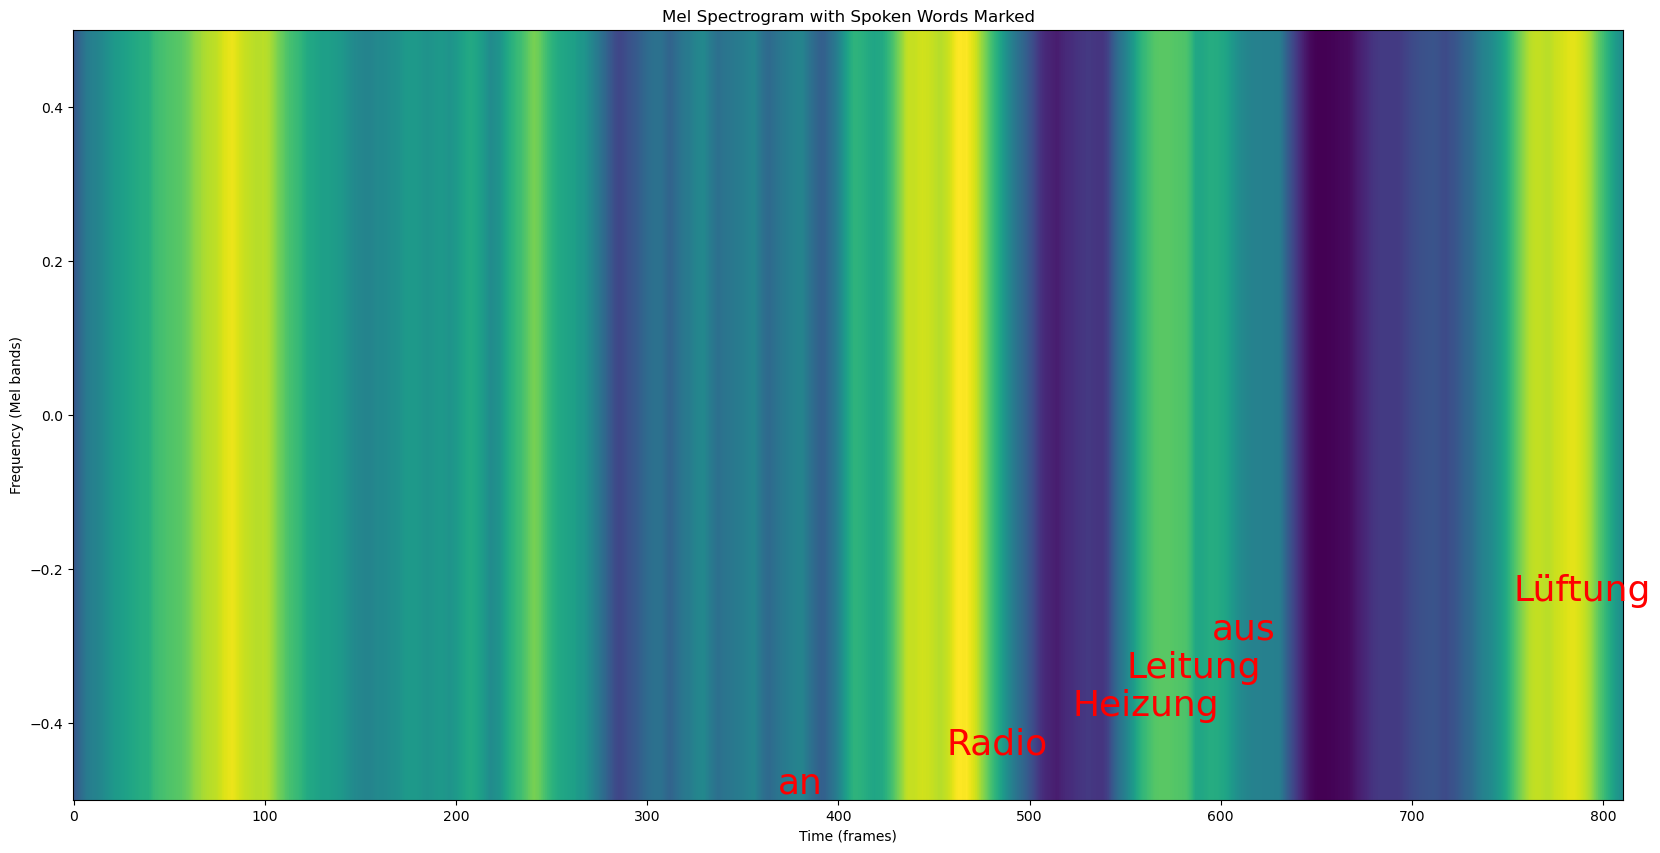

In [49]:
import matplotlib.pyplot as plt
melspect_indices = list(range(12, 76))  # melspect_0 to melspect_63

# Extract Mel spectrogram data
melspect_data = segments_1.cpu().numpy()[:, :, melspect_indices, :]

# Average across segments to create a single spectrogram (if needed)
# Here, averaging over the 0-axis (segments) to get a (frames, features) shape
#print(melspect_data.shape)
spectrogram = np.mean(melspect_data, axis=2)
spectrogram = np.mean(spectrogram, axis=2)
# Transpose to get the correct shape for plotting (features, frames)
spectrogram = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))
spectrogram = spectrogram.T
#spectrogram = spectrogram[:, ::downsample_factor]
# Plotting the spectrogram
plt.figure(figsize=(20, 10))
plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
plt.title('Mel Spectrogram with Spoken Words Marked')
plt.xlabel('Time (frames)')
plt.ylabel('Frequency (Mel bands)')

# Mark the spoken words on the spectrogram
predictions_1 = words_position_1
predictions_2 = words_position_2
predictions_3 = words_position_3
predictions_4 = words_position_4
# Add text annotations
"""
for idx, word in predictions:
    print(idx)
    plt.text(idx, -0.5, word, color='red', fontsize=12, ha='center', va='bottom')"""
unique_predictions = []
last_word = None
range_limit = 68  # Define a range to skip close duplicate words

for idx, word in predictions_2:
    if last_word is None or word != last_word or (unique_predictions and idx - unique_predictions[-1][0] > range_limit):
        unique_predictions.append((idx, word))
        last_word = word

# Add text annotations
position = -0.5
last_word = None
last_idx = 0
final_predictions = []
for idx, word in unique_predictions:
    if last_word is None:
        last_idx = idx
        last_word = word
        continue
    elif word in activation_keywords and last_word in device_keywords:
        command = last_word + " " + word
        final_predictions.append((command, last_idx, idx))
        last_word = word
        last_idx = idx
    else:
        last_word = word
        last_idx = idx
print(final_predictions)
for idx, word in unique_predictions:
    plt.text(idx, position, word, color='red', fontsize=26, ha='center', va='bottom')
    position += 0.05

plt.show()

In [45]:
"""def compute_cost(predictions, annotations):
    cost = 0
    for pred in predictions:
        if pred['type'] == 'true_positive':
            cost -= 1
        elif pred['type'] == 'false_negative':
            cost += 0.5
        elif pred['type'] == 'false_positive':
            command = pred['command']
            if command in ["Fernseher an", "Fernseher aus", "Licht an", "Licht aus", "Radio an", "Radio aus", "Staubsauger an", "Staubsauger aus"]:
                cost += 2
            elif command in ["Heizung an", "Heizung aus", "Lüftung an", "Lüftung aus"]:
                cost += 3
            elif command in ["Ofen an", "Ofen aus", "Alarm an", "Alarm aus"]:
                cost += 4
        elif pred['type'] == 'cross_trigger':
            if pred['correct_device']:
                cost += 0.1
            else:
                cost += 1
    return cost"""
